# tvAR2
## 1500 replications
###### Author: Mokhtar Z. Alaya <alayaelm@utc.fr>

Let $\phi(u) = 1.4 + \sin(2\pi u), \psi(u) = 1.05,$ and define  
\begin{equation*}
Y_{t,T} = m^\star(\frac tT, X_{t,T}) + \varepsilon_{t,T},
\end{equation*}
where
\begin{equation*}
X_{t,T} = (Y_{t-1, T}, Y_{t-2, T}), \quad m^\star(\frac tT, X_{t,T}) = \frac{2}{\psi(\frac tT)} \cos(\phi(\frac tT)) Y_{t-1, T} - \frac{1}{(\psi(\frac tT)^2}  Y_{t-2, T}, \quad \text{ and } \varepsilon_{t, T} \sim \mathcal{N}(0,1)
\end{equation*}


In [3]:
import sys
sys.path.append('D:/Users/tiniojan/ExperimentsPhD/June_19_24/wasslsp')
import warnings
warnings.filterwarnings('ignore')

import torch

import numpy as np
import scipy as scp

import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
%matplotlib inline
#from matplotlib import rc
#rc('font', **{'family': 'sans-serif', 'sans-serif': ['Computer Modern Roman']})
params = {'axes.labelsize': 12,
          'font.size': 12,
          'legend.fontsize': 12,
          'xtick.labelsize': 12,
          'ytick.labelsize': 8, # 10
          'text.usetex': True,
          'figure.figsize': (10, 8)}
plt.rcParams.update(params)

import seaborn as sns

from src.utils import *
from src.kernels import Kernel

from scipy.stats import wasserstein_distance
from mpl_toolkits.mplot3d import Axes3D

# Plot process

In [5]:
T = 1000
n_replications = 1000
d = 2


phi_star = lambda u: 1.4 + np.sin(2 * np.pi * u)
psi_star = lambda  u: 1.05
sigma_star = lambda u: 1.0

m_star = lambda u, x, y: 2/(psi_star(u)) * np.cos(phi_star(u)) * x - 1/(psi_star(u)**2) * y

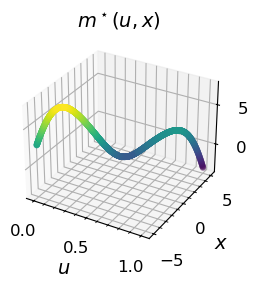

In [6]:
# Plot of m^star
plt.rcParams['text.usetex'] = False


u = np.linspace(0., 1., T)
x = np.linspace(-5, 5, T)
u_mesh, y_mesh = np.meshgrid(u, x)

m_star_vals_mesh = m_star(u_mesh, y_mesh, y_mesh)
m_star_vals = m_star(u, x, x)

# ax = plt.axes(projection='3d')
# ax.plot3D(u, x, m_star_vals, 'gray')
# plt.show()
plt.rcParams["figure.figsize"] = (10,3)
fig = plt.figure()
ax = plt.axes(projection='3d')
plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
plt.minorticks_on()
# ax.contour3D(u_mesh, y_mesh, m_star_vals_mesh, 50, cmap='binary')
ax.scatter(u, x, m_star_vals, c=m_star_vals, cmap='viridis', linewidth=0.1);
ax.set_xlabel(r'$u$', fontsize=14)
ax.set_ylabel(r'$x$', fontsize=14)
ax.set_title(r'$m^\star(u,x)$', fontsize=14)
plt.savefig("m_star_tvAR_2.pdf", dpi=300)
plt.tight_layout()
plt.show()

In [7]:

T = 1000
n_replications = 1
d = 2


X_tvar_2 = np.zeros(T)
X_tvar_2_mean = np.zeros(T)

X_tvar_2_replications = np.zeros((n_replications, T))

X_dict = {}

for replication in range(n_replications):
    t = 2
    epsilon = np.random.normal(size=(T))
    X = np.zeros((T,d))
    while t <= T-1 :
        X_tvar_2[t] = m_star(t/T, X_tvar_2[t-1], X_tvar_2[t-2]) + sigma_star(t/T) * epsilon[t]
        X[t] = [X_tvar_2[t-1], X_tvar_2[t-2]]
        t += 1
        
    X_dict[str(replication)] = X
    X_tvar_2_replications[replication] = X_tvar_2

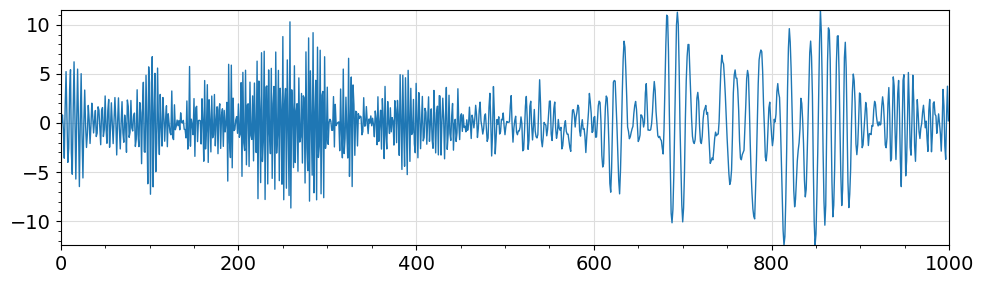

In [8]:
#path_fig = 'D:/ExperimentsPhD/Experiment results'
plt.rcParams["figure.figsize"] = (10,3)

u_var = np.linspace(0., 1., T)

for replication in range(n_replications):
    plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
    plt.minorticks_on()
    plt.plot(X_tvar_2_replications[replication], lw=1)
    # plt.plot(X_tvar_2_replications_u_var[replication], lw=2)
    # plt.plot(X_tvar_2_mean)
    # plt.xticks(np.arange(0, T+1, 200, dtype=int))
    plt.xlim(0, T)
    plt.ylim(min(X_tvar_2_replications[replication]) , max(X_tvar_2_replications[replication]))
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    # plt.title(r'$Y_{t,T} = m^\star(\frac{t}{T}, X_{t,T}) + \varepsilon_{t,T}$')
    # plt.legend()
    plt.tight_layout()
    #plt.savefig(path_fig+"tv_AR_2_gaussian.pdf", dpi=300)

## NW estimator for the conditional mean function

Note that NW estimator of $m^\star(u,\boldsymbol{x})$ is given by  $\hat m(u,\boldsymbol{x}) 
% = \E_{\hat{\pi}_t(\cdot|\boldsymbol{x})}[Y_{t,T}| \boldsymbol{X}_{t,T}=\boldsymbol{x}]
= \sum_{a=1}^T   \omega_{a}(u, \boldsymbol{x}) Y_{a,T}$.

In [11]:
space_kernel = "silverman"
time_kernel = "tricube"
bandwidth = T **(-0.4 / (d+1))
Y_t_T = X_tvar_2_replications[0]

GaussUnifKernel = Kernel(T=T, bandwidth=bandwidth, space_kernel=space_kernel, time_kernel=time_kernel)
GaussUnifKernel 

Kernel(T=1000, bandwidth=0.39810717055349726, space_kernel='silverman',
       time_kernel='tricube')

In [12]:
weights = {}
for t in range(T):
    weights[str(t)] = GaussUnifKernel.fit(X_dict['0'], t)

In [13]:
weights['0'].shape, Y_t_T.shape

((1000,), (1000,))

In [14]:
m_hat= [np.sum(weights[str(t)] * Y_t_T) for t in range(T)]
# for t in range(T): m_hat.append(np.sum(weights[str(t)] * Y_t_T))

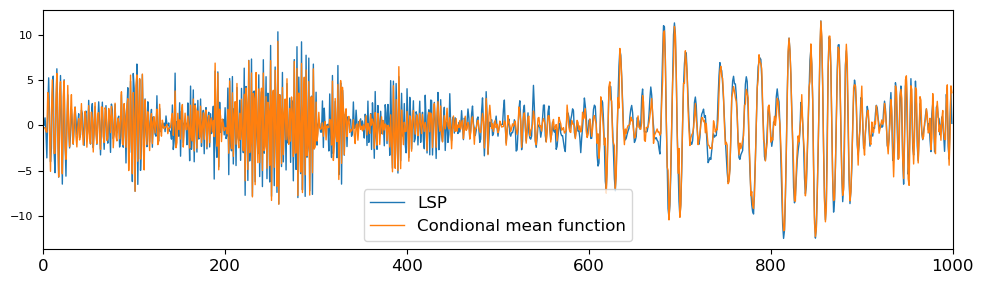

In [15]:
#path_fig = "/Users/mzalaya/Library/CloudStorage/Dropbox/research/git/wasslsp/figs/"
plt.rcParams["figure.figsize"] = (10,3)

u_var = np.linspace(0., 1., T)

for replication in range(n_replications):
    plt.plot(X_tvar_2_replications[replication], lw=1, label="LSP")
    plt.plot(np.array(m_hat), lw=1, label="Condional mean function")
    # plt.plot(X_tvar_2_replications_u_var[replication], lw=2)
    # plt.plot(X_tvar_2_mean)
    # plt.xticks(np.arange(0, T+1, 200, dtype=int))
    plt.xlim(0, T)
    # plt.title(r'$Y_{t,T} = m^\star(\frac{t}{T}, X_{t,T}) + \varepsilon_{t,T}$')
    plt.legend()
    plt.tight_layout()
    #plt.savefig(path_fig+"locally_process_conditional_mean_Guassina_space_kernel_uniform_tiem_kernel.pdf", dpi=150)

In [16]:
## Dimensions

In [17]:
times_T = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
times_t = [150, 200, 250, 300, 350, 400, 450, 500] 

d = 2
n_replications = 1500

In [18]:

X_tvar_2 = {}
X_tvar_2_replications = {}
X_dict = {}

# "T:"+str(T
for T in times_T:
    X_tvar_2_replications[f"T:{T}"] = np.zeros((n_replications, T))
    X_dict[f"T:{T}"] = {}

In [19]:
# X_dict

In [20]:
for T in times_T:
    u_var = np.linspace(0., 1., T)

    for replication in range(n_replications):
        t = 2
        epsilon = np.random.normal(size=(T))
        X = np.zeros((T,d))
        X_tvar_2_T = np.zeros(T)
        while t <= T-1 :
            X_tvar_2_T[t] = m_star(t/T, X_tvar_2_T[t-1], X_tvar_2_T[t-2]) + sigma_star(t/T) * epsilon[t]
            
            X[t] = [X_tvar_2_T[t-1], X_tvar_2_T[t-2]]
            t += 1

        X_tvar_2_replications[f"T:{T}"][replication] = X_tvar_2_T
        X_dict[f"T:{T}"][str(replication)] = X


In [21]:
X_tvar_2 = {}

for t in times_t:
    for T in times_T:
        X_tvar_2[f"t:{t}_T:{T}"] = {}

# X_tvar_2

In [22]:
for t in times_t:
    for T in times_T:
        X_tvar_2[f"t:{t}_T:{T}"] = []


for t in times_t:
    for replication in range(n_replications):
        for T in times_T:
            z = X_tvar_2_replications[f"T:{T}"][replication][t-1]
            X_tvar_2[f"t:{t}_T:{T}"].append(z)

for t in times_t:
    for T in times_T:
        X_tvar_2[f"t:{t}_T:{T}"] = np.array(X_tvar_2[f"t:{t}_T:{T}"])

In [23]:
plt.rcParams["figure.figsize"] = (5,4)

norm_X_tvar_2 = {}
for t in times_t:
    for T in times_T:
        norm_X_tvar_2[f"t:{t}_T:{T}"] = scp.stats.norm.cdf(X_tvar_2[f"t:{t}_T:{T}"])

        # sns.lineplot(
            # x=X_tvar_2[f"t:{t}_T:{T}"], y=norm_X_tvar_2[f"t:{t}_T:{str(T)}"], lw=2, markers=True,
            # label=f"(t,T)={t, T}",  drawstyle='steps-mid',          
        # )
        # plt.legend()
        # plt.tight_layout()

# Nadara-Watson estimator: Gaussian kernel

In [25]:
space_kernel = "gaussian"
time_kernel = "uniform"
xi = 0.4 / (2*(d+1))

gaussian_kernel = {}
gaussian_weights = {}

for t in times_t:
    for T in times_T:
        gaussian_weights[f"t:{t}_T:{T}"] = {}
    
for T in times_T:
    bandwidth = T **(-xi) #/ 10
    gaussian_kernel[f"T:{T}"] = Kernel(T=T, bandwidth=bandwidth, space_kernel=space_kernel, time_kernel=time_kernel)

In [26]:
gaussian_kernel

{'T:1000': Kernel(T=1000, bandwidth=0.6309573444801932, time_kernel='uniform'),
 'T:2000': Kernel(T=2000, bandwidth=0.6024643228025249, time_kernel='uniform'),
 'T:3000': Kernel(T=3000, bandwidth=0.5863972383946078, time_kernel='uniform'),
 'T:4000': Kernel(T=4000, bandwidth=0.5752580002835659, time_kernel='uniform'),
 'T:5000': Kernel(T=5000, bandwidth=0.5667636646017326, time_kernel='uniform'),
 'T:6000': Kernel(T=6000, bandwidth=0.5599164796373463, time_kernel='uniform'),
 'T:7000': Kernel(T=7000, bandwidth=0.5541918448319288, time_kernel='uniform'),
 'T:8000': Kernel(T=8000, bandwidth=0.5492802716530589, time_kernel='uniform'),
 'T:9000': Kernel(T=9000, bandwidth=0.5449841010728054, time_kernel='uniform'),
 'T:10000': Kernel(T=10000, bandwidth=0.5411695265464637, time_kernel='uniform')}

In [27]:
for replication in range(n_replications):
    for t in times_t:
        for T in times_T:
            # print(X_dict[f"T:{T}"][str(replication)].shape, "\n")
            # print(gaussian_kernel[f"T:{T}"], "\n")
            # print(gaussian_weights[f"t:{t}_T:{T}"], "\n")
            gaussian_weights[f"t:{t}_T:{T}"][str(replication)] = \
            gaussian_kernel[f"T:{T}"].fit(X_dict[f"T:{T}"][str(replication)], t-1)

In [28]:
n_replications

1500

In [29]:
gaussian_weights_tensor =  {} #= torch.empty((len(times_t), len(times_T), )

# torch.zeros((len(times_t), len(times_T), n_replications, None))
# gaussian_weights_tensor.size() # torch.Size([len(times_t), len(times_T), n_replications])

for i_t in range(len(times_t)):
    for i_T in range(len(times_T)):
        gaussian_weights_tensor[f"t:{times_t[i_t]}_T:{times_T[i_T]}"] = {}


for i_t in range(len(times_t)):
    for i_T in range(len(times_T)):  
        for replication in range(n_replications):
            gaussian_weights_tensor[f"t:{times_t[i_t]}_T:{times_T[i_T]}"][str(replication)] =\
            gaussian_weights[f"t:{times_t[i_t]}_T:{times_T[i_T]}"][str(replication)]

\begin{align}
  \omega_{a}(\frac t T, \boldsymbol{x})=\frac{\displaystyle  K_{h,1}(\frac{t}{T} - \frac{a}{T})\prod_{j=1}^dK_{h,2}(x^j- X_{a,T}^j)}{\displaystyle \sum_{a=1}^TK_{h,1}(\frac{t}{T} - \frac{a}{T})\prod_{j=1}^dK_{h,2}(x^j - X_{a,T}^j)}.
 \end{align}

The associated conditional CDF to $\hat{\pi}_t(\cdot|\boldsymbol{x})$ is defined as, for all $y \in \R,$  
\begin{equation}
  \hat{F}_{t}(y|\boldsymbol{x})=\sum_{a=1}^T\omega_{a}(\frac tT,\boldsymbol{x}) \mathbf{1}_{Y_{a,T}\leq y}. %, \quad \text{for all $y\in\R$}. %  \ind{}(Y_{a,T}\leq y) 
\end{equation}


In [32]:
empirical_cds = {}
for t in times_t:
    for T in times_T:
        empirical_cds[f"t:{t}_T:{T}"] = scp.stats.norm.cdf(X_tvar_2[f"t:{t}_T:{T}"])


In [33]:
def eval_univariate(x, weights):
        """Inner function for ECDF of one variable."""
        sorter = x.argsort()
        x = x[sorter]
        weights = weights[sorter]
        y = weights.cumsum()

        # if self.stat in ["percent", "proportion"]:
        y = y / y.max()
        # if self.stat == "percent":
            # y = y * 100

        # x = np.r_[-np.inf, x]
        # y = np.r_[0, y]
        x = np.r_[x]
        y = np.r_[y]

        # if self.complementary:
            # y = y.max() - y

        return y, x

In [67]:
x_rep = {} 
y_rep = {} 

wasserstein_distances = {}

for t in times_t:
    for T in times_T:
        x_rep[f"t:{t}_T:{str(T)}"] = np.zeros((n_replications, T))
        y_rep[f"t:{t}_T:{str(T)}"] = np.zeros((n_replications, T))
        wasserstein_distances[f"t:{t}_T:{T}"] = {}

for replication in range(n_replications):
    for t in times_t:
        for T in times_T:
            y, x = eval_univariate(
                X_tvar_2_replications[f"T:{T}"][replication], gaussian_weights_tensor[f"t:{t}_T:{str(T)}"][str(replication)]
                # gaussian_weights_tensor[f"t:{t}_T:{str(T)}"][str(replication)] * X_tvar_2_replications[f"T:{T}"][replication]
            )
            x_rep[f"t:{t}_T:{str(T)}"][replication] = x
            y_rep[f"t:{t}_T:{str(T)}"][replication] = y
            distance = wasserstein_distance(y, scp.stats.norm.cdf(X_tvar_2_replications[f"T:{T}"][replication]))
            wasserstein_distances[f"t:{t}_T:{T}"][str(replication)] = distance
   
   
            # plt.plot(x, y, label=f"t:{t}_T:{T}")# _replication:{replication}")
            # plt.xlabel(r'$y$')
            # plt.ylabel(r'$\hat{F}_t(y|x)$')
            # plt.xlim(-18, 18)
            # plt.title(r'NW CDF estimators, $\hat{F}_{t}(y|{x})=\sum_{a=1}^T\omega_{a}(\frac{t}{T},{x})\mathbf{1}_{Y_{a,T}\leq y}$')
            # plt.legend()
            # plt.tight_layout()
            # plt.savefig(path_fig+"nadar_watson_weights_", dpi=150)

In [69]:
wass_distances_all_replications = {}

for t in times_t:
    for T in times_T:
        wass_distances_all_replications[f"t:{t}_T:{T}"] = []

for t in times_t:
    for T in times_T:       
        for replications in range(n_replications):
            wass_distances_all_replications[f"t:{t}_T:{T}"].append(wasserstein_distances[f"t:{t}_T:{T}"][str(replication)])
        

In [71]:
plt.rcParams["figure.figsize"] = (10,3)
wass_distances_empirical_meanNW = {}
for t in times_t:
    for T in times_T:
        wass_distances_empirical_meanNW[f"t:{t}_T:{T}"] = wasserstein_distance(
            empirical_cds[f"t:{t}_T:{T}"], y_rep[f"t:{t}_T:{T}"].mean(axis=0)
        )

In [73]:
wass_distances_empirical_meanNW

{'t:150_T:1000': 0.11672092677135827,
 't:150_T:2000': 0.1053678871756828,
 't:150_T:3000': 0.09602264165181626,
 't:150_T:4000': 0.10445607620450485,
 't:150_T:5000': 0.08591332812324778,
 't:150_T:6000': 0.09839477203300918,
 't:150_T:7000': 0.098033630894136,
 't:150_T:8000': 0.10172303969208663,
 't:150_T:9000': 0.09908497434480333,
 't:150_T:10000': 0.09644127335673765,
 't:200_T:1000': 0.1398789673590886,
 't:200_T:2000': 0.09786114385420724,
 't:200_T:3000': 0.09809769226220516,
 't:200_T:4000': 0.09192360986958317,
 't:200_T:5000': 0.0913980539448961,
 't:200_T:6000': 0.08909878501996121,
 't:200_T:7000': 0.0950415510523562,
 't:200_T:8000': 0.09142113086747812,
 't:200_T:9000': 0.09643809919742333,
 't:200_T:10000': 0.09365661520864535,
 't:250_T:1000': 0.15292771070790248,
 't:250_T:2000': 0.10579890011075821,
 't:250_T:3000': 0.10364583995408054,
 't:250_T:4000': 0.09573346202901611,
 't:250_T:5000': 0.09491628506076155,
 't:250_T:6000': 0.09928702071632263,
 't:250_T:7000':

In [75]:
plt.rcParams["figure.figsize"] = (10,3)
wass_times_t = {}

for t in times_t:
    wass_times_t[f"t:{t}"] = []

for t in times_t:
    for T in times_T:
        wass_times_t[f"t:{t}"].append(wass_distances_empirical_meanNW[f"t:{t}_T:{T}"])

In [77]:
import pickle 
with open(f"wass_distance{times_t}{times_T}_{n_replications}.pkl", 'wb') as f:
    pickle.dump(wass_times_t, f)

# wass_times_t

\begin{align*}
    \sup_{\boldsymbol{x}\in \mathcal{X}, \frac{t}{T}\in I_h} E\big[W_1\big(\hat{\pi}_t(\cdot|\boldsymbol{x}), \pi_t^\star(\cdot|\boldsymbol{x})\big)\big]
    &= O_P\Big(\frac{1}{T^{\frac{1}{2}} h^{d + 1 - \frac{1}{p}(1-\nu)}} + \frac{1}{T^\nu h^{d + \nu - 1}} + h\Big).
\end{align*}

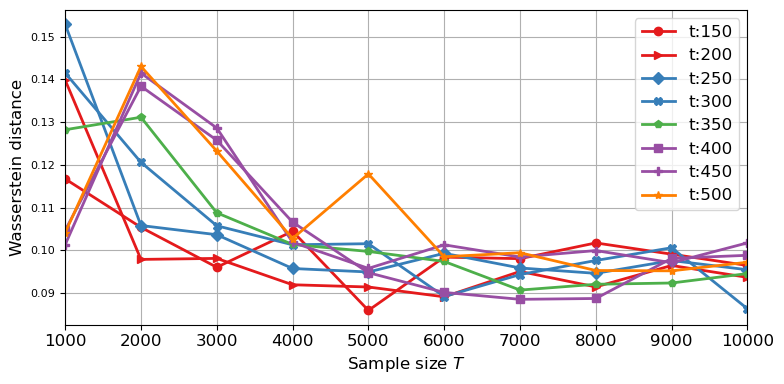

In [79]:

plt.rcParams["figure.figsize"] = (8,4)
colors = plt.cm.Set1(np.linspace(0, .5, 8))
#markers = ['o', '>', 'D', 'X', "p"]
markers = ['o', '>', 'D', 'X', "p", 's', 'P', '*'] 

for i, t in zip(range(len(times_t)), times_t):
    plt.plot(times_T, wass_times_t[f"t:{t}"], label=f"t:{t}", color=colors[i], marker=markers[i], markersize=6, lw=2)
    plt.xlim(np.array(times_T).min(), np.array(times_T).max())
    #plt.title(r'Wasserstein distance $W_1\left(\hat{\pi}_t(\cdot|{x}), \pi_t^\star(\cdot|{x})\right)$')
    plt.xlabel(r'Sample size ${T}$ ')
    plt.ylabel("Wasserstein distance")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    #plt.savefig(path_fig+f"wass_distance{times_t}{times_T}_{n_replications}_kernel_{kernel}", dpi=150)

# K1=Tricube ; K2=Silverman 

In [43]:
space_kernel = "silverman" 
time_kernel = "tricube"
xi = 0.4 / (2*(d+1))

gaussian_kernel = {}
gaussian_weights = {}

for t in times_t:
    for T in times_T:
        gaussian_weights[f"t:{t}_T:{T}"] = {}
    
for T in times_T:
    bandwidth = T **(-xi) #/ 10
    gaussian_kernel[f"T:{T}"] = Kernel(T=T, bandwidth=bandwidth, space_kernel=space_kernel, time_kernel=time_kernel)
    

########



In [ ]:
for replication in range(n_replications):
    for t in times_t:
        for T in times_T:
            # print(X_dict[f"T:{T}"][str(replication)].shape, "\n")
            # print(gaussian_kernel[f"T:{T}"], "\n")
            # print(gaussian_weights[f"t:{t}_T:{T}"], "\n")
            gaussian_weights[f"t:{t}_T:{T}"][str(replication)] = \
            gaussian_kernel[f"T:{T}"].fit(X_dict[f"T:{T}"][str(replication)], t-1)

#######

In [ ]:
gaussian_weights_tensor =  {} #= torch.empty((len(times_t), len(times_T), )

# torch.zeros((len(times_t), len(times_T), n_replications, None))
# gaussian_weights_tensor.size() # torch.Size([len(times_t), len(times_T), n_replications])

for i_t in range(len(times_t)):
    for i_T in range(len(times_T)):
        gaussian_weights_tensor[f"t:{times_t[i_t]}_T:{times_T[i_T]}"] = {}


for i_t in range(len(times_t)):
    for i_T in range(len(times_T)):  
        for replication in range(n_replications):
            gaussian_weights_tensor[f"t:{times_t[i_t]}_T:{times_T[i_T]}"][str(replication)] =\
            gaussian_weights[f"t:{times_t[i_t]}_T:{times_T[i_T]}"][str(replication)]
            
######



In [ ]:
empirical_cds = {}
for t in times_t:
    for T in times_T:
        empirical_cds[f"t:{t}_T:{T}"] = scp.stats.norm.cdf(X_tvar_2[f"t:{t}_T:{T}"])
        
#######


In [ ]:

x_rep = {} 
y_rep = {} 

wasserstein_distances = {}

for t in times_t:
    for T in times_T:
        x_rep[f"t:{t}_T:{str(T)}"] = np.zeros((n_replications, T))
        y_rep[f"t:{t}_T:{str(T)}"] = np.zeros((n_replications, T))
        wasserstein_distances[f"t:{t}_T:{T}"] = {}

for replication in range(n_replications):
    for t in times_t:
        for T in times_T:
            y, x = eval_univariate(
                X_tvar_2_replications[f"T:{T}"][replication], gaussian_weights_tensor[f"t:{t}_T:{str(T)}"][str(replication)]
                # gaussian_weights_tensor[f"t:{t}_T:{str(T)}"][str(replication)] * X_tvar_2_replications[f"T:{T}"][replication]
            )
            x_rep[f"t:{t}_T:{str(T)}"][replication] = x
            y_rep[f"t:{t}_T:{str(T)}"][replication] = y
            distance = wasserstein_distance(y, scp.stats.norm.cdf(X_tvar_2_replications[f"T:{T}"][replication]))
            wasserstein_distances[f"t:{t}_T:{T}"][str(replication)] = distance
   
   
            # plt.plot(x, y, label=f"t:{t}_T:{T}")# _replication:{replication}")
            # plt.xlabel(r'$y$')
            # plt.ylabel(r'$\hat{F}_t(y|x)$')
            # plt.xlim(-18, 18)
            # plt.title(r'NW CDF estimators, $\hat{F}_{t}(y|{x})=\sum_{a=1}^T\omega_{a}(\frac{t}{T},{x})\mathbf{1}_{Y_{a,T}\leq y}$')
            # plt.legend()
            # plt.tight_layout()
            # plt.savefig(path_fig+"nadar_watson_weights_", dpi=150)
            
#######

In [ ]:
wass_distances_all_replications = {}

for t in times_t:
    for T in times_T:
        wass_distances_all_replications[f"t:{t}_T:{T}"] = []

for t in times_t:
    for T in times_T:       
        for replications in range(n_replications):
            wass_distances_all_replications[f"t:{t}_T:{T}"].append(wasserstein_distances[f"t:{t}_T:{T}"][str(replication)])

#######

plt.rcParams["figure.figsize"] = (10,3)
wass_distances_empirical_meanNW = {}
for t in times_t:
    for T in times_T:
        wass_distances_empirical_meanNW[f"t:{t}_T:{T}"] = wasserstein_distance(
            empirical_cds[f"t:{t}_T:{T}"], y_rep[f"t:{t}_T:{T}"].mean(axis=0)
        )

wass_distances_empirical_meanNW

#######

In [ ]:
plt.rcParams["figure.figsize"] = (8,4)
colors = plt.cm.Set1(np.linspace(0, .5, 8))
#markers = ['o', '>', 'D', 'X', "p"]
markers = ['o', '>', 'D', 'X', "p", 's', 'P', '*'] 

for i, t in zip(range(len(times_t)), times_t):
    plt.plot(times_T, wass_times_t[f"t:{t}"], label=f"t:{t}", color=colors[i], marker=markers[i], markersize=6, lw=2)
    plt.xlim(np.array(times_T).min(), np.array(times_T).max())
    #plt.title(r'Wasserstein distance $W_1\left(\hat{\pi}_t(\cdot|{x}), \pi_t^\star(\cdot|{x})\right)$')
    plt.xlabel(r'Sample size ${T}$ ')
    plt.ylabel("Wasserstein distance")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    #plt.savefig(path_fig+f"wass_distance{times_t}{times_T}_{n_replications}_kernel_{kernel}", dpi=150)